# Leer datasets

In [1]:
import pandas as pd
import numpy as np

moon = pd.read_csv('../../../data/sintetica/no separable/moon.csv')
moon.head()

,X1,X2,label
0,0.682988,-0.345203,1
1,2.040990,-0.131615,1
2,-0.139752,0.454391,1
3,0.885748,0.286342,0
4,1.182459,-0.497711,1


In [2]:
moon.drop(columns=['label'], inplace=True)

# Realizamos los clusters

In [3]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, SpectralClustering, AffinityPropagation, Birch, OPTICS, BisectingKMeans
from sklearn.mixture import GaussianMixture
n_clusters = 2
clustering_algorithms = {
    'KMeans': KMeans(n_clusters=n_clusters, random_state=42),
    'DBSCAN': DBSCAN(eps=0.2, min_samples=5),
    'AgglomerativeClustering': AgglomerativeClustering(n_clusters=n_clusters),
    'MeanShift': MeanShift(),
    'SpectralClustering': SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors'),
    'AffinityPropagation': AffinityPropagation(),
    'Birch': Birch(n_clusters=n_clusters),
    'OPTICS': OPTICS(min_samples=5, cluster_method='xi', xi=0.05),
    'BisectingKMeans': BisectingKMeans(n_clusters=n_clusters, random_state=42),
    'GaussianMixture': GaussianMixture(n_components=n_clusters, random_state=42)
}
results = {}
for name, algorithm in clustering_algorithms.items():
    try:
        algorithm.fit(moon)
        if hasattr(algorithm, 'labels_'):
            labels = algorithm.labels_
        elif hasattr(algorithm, 'predict'):
            labels = algorithm.predict(moon)
        else:
            labels = algorithm.means_.argmax(axis=0)  # For GaussianMixture
        results[name] = labels
    except Exception as e:
        print(f"Error with {name}: {e}")

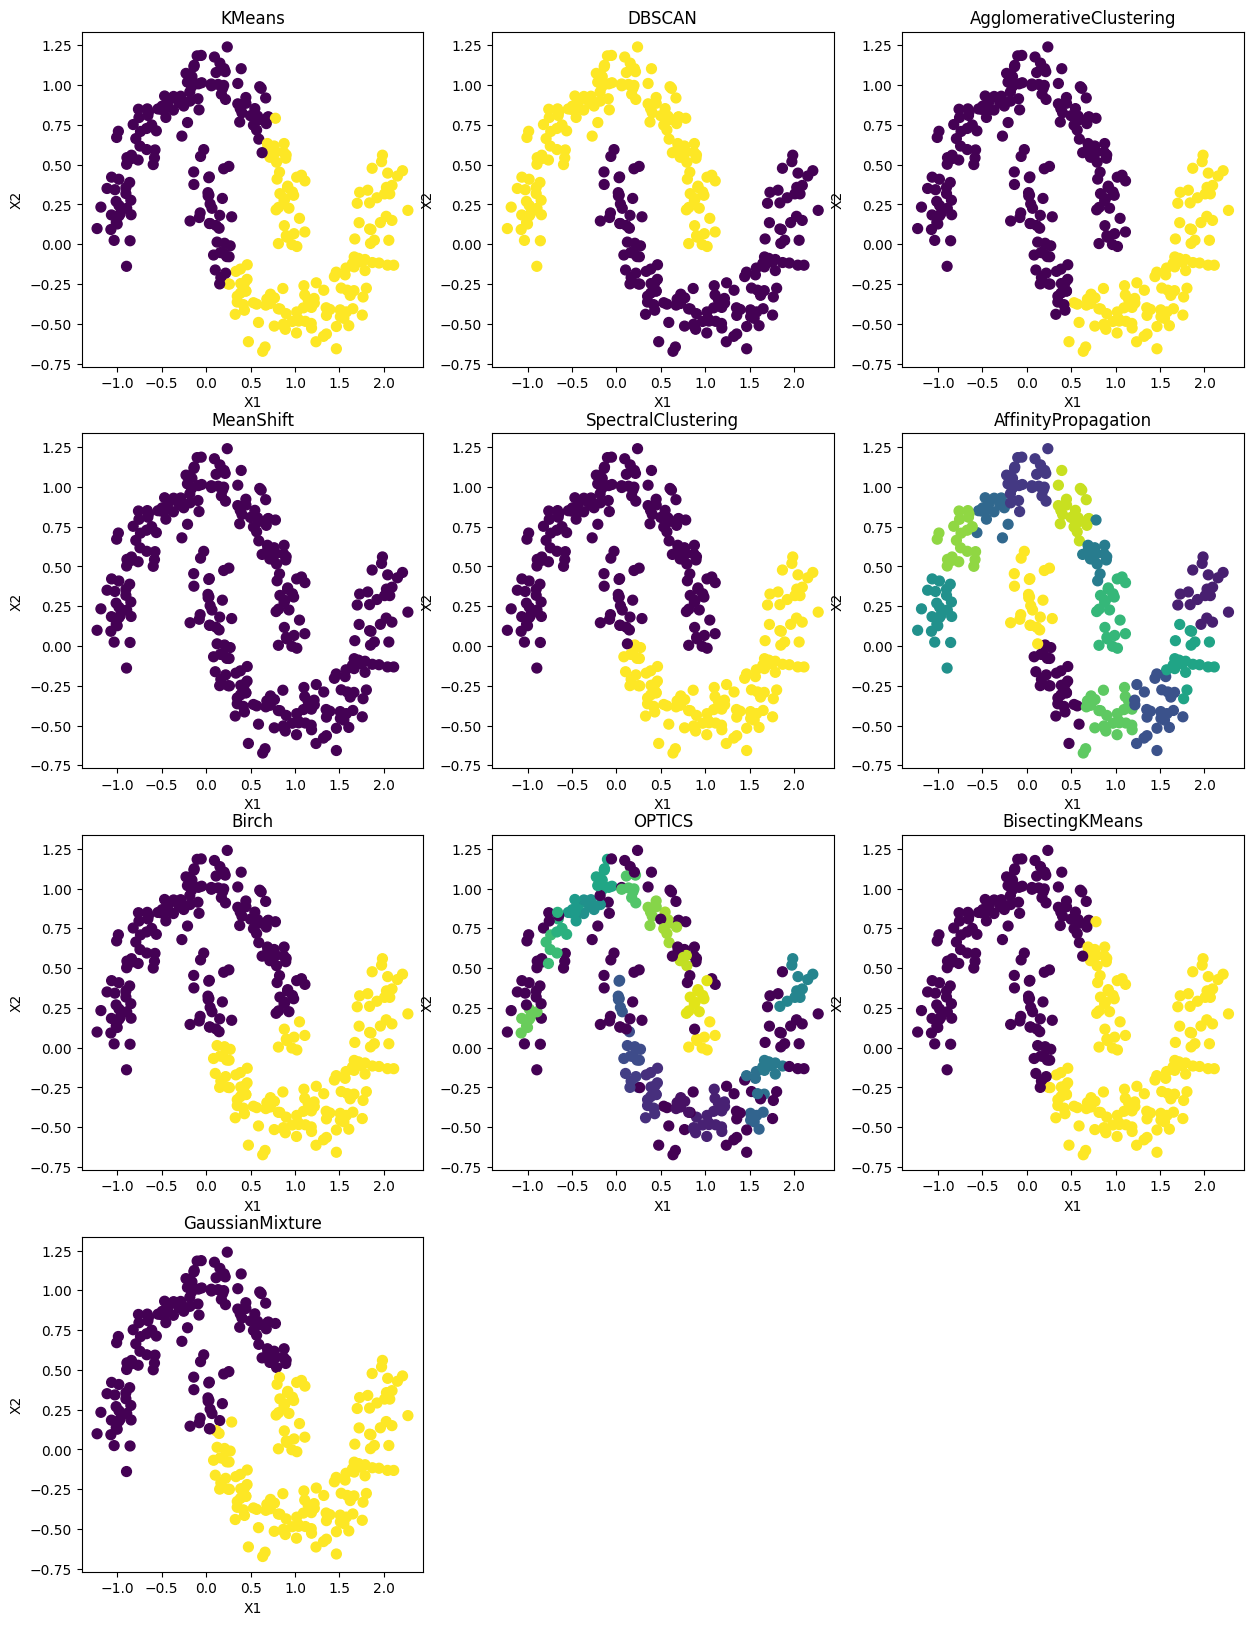

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 20))
for i, (name, labels) in enumerate(results.items(), 1):
    plt.subplot(4, 3, i)
    plt.scatter(moon.iloc[:, 0], moon.iloc[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(name)
    plt.xlabel(moon.columns[0])
    plt.ylabel(moon.columns[1])

In [9]:
#definimos dunn index
def dunn_index(data, labels):
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return 0.0

    inter_cluster_distances = []
    intra_cluster_distances = []

    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            cluster_i = data[labels == unique_labels[i]]
            cluster_j = data[labels == unique_labels[j]]
            inter_distance = np.linalg.norm(cluster_i.mean(axis=0) - cluster_j.mean(axis=0))
            inter_cluster_distances.append(inter_distance)

        intra_distance = np.mean([np.linalg.norm(data[labels == unique_label] - data[labels == unique_label].mean(axis=0)) for unique_label in unique_labels])
        intra_cluster_distances.append(intra_distance)

    dunn_index_value = min(inter_cluster_distances) / max(intra_cluster_distances)
    return dunn_index_value

In [22]:
#podrias generar una metrica en que se calcule el valor maximo de distancia (entre las menores distancias de cada punto con otro dentro del mismo cluster) dividido por el valor minimo de distancia entre cualquier punto de un cluster con otro punto de otro cluster
import numpy as np
from sklearn.metrics import pairwise_distances

def custom_metric(X, labels):
    X = np.array(X)
    distances = pairwise_distances(X)
    n = len(X)
    
    # Numerador: máximo de las mínimas distancias dentro del mismo cluster
    max_min_intra = -np.inf
    for i in range(n):
        same_cluster = (labels == labels[i])
        same_cluster[i] = False  # Exclude itself
        if np.any(same_cluster):
            min_dist = np.min(distances[i][same_cluster])
            max_min_intra = max(max_min_intra, min_dist)
    
    # Denominador: mínima distancia entre puntos de distintos clusters
    min_inter = np.inf
    for i in range(n):
        other_cluster = (labels != labels[i])
        if np.any(other_cluster):
            min_dist = np.min(distances[i][other_cluster])
            min_inter = min(min_inter, min_dist)

    M = max_min_intra / min_inter if min_inter != 0 else np.inf
    return 1 /( 1 + M)


In [29]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from permetrics import ClusteringMetric
def evaluate_clustering(data, labels):
    if len(set(labels)) < 2:
        return {
            'Silhouette Score': None,
            'Calinski-Harabasz Score': None,
            'Davies-Bouldin Score': None,
            'Dunn Index': None,
            'custom_metric': None,
            'dbcv': None
        }
    
    silhouette = silhouette_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    dunn = dunn_index(data.values, labels)
    custom = custom_metric(data.values, labels)
    dbcv = ClusteringMetric(X=data.values, y_pred=labels).DBCVI()

    return {
        'Silhouette Score': silhouette,
        'Calinski-Harabasz Score': calinski_harabasz,
        'Davies-Bouldin Score': davies_bouldin,
        'Dunn Index': dunn,
        'custom_metric': custom,
        'dbcv': dbcv
    }
evaluation_results = {}
for name, labels in results.items():
    evaluation_results[name] = evaluate_clustering(moon, labels)
evaluation_df = pd.DataFrame(evaluation_results).T
evaluation_df = evaluation_df.rename(columns={
    'Silhouette Score': 'Silhouette',
    'Calinski-Harabasz Score': 'Calinski-Harabasz',
    'Davies-Bouldin Score': 'Davies-Bouldin',
    'Dunn Index': 'Dunn',
    'custom_metric': 'Custom Metric'
})
evaluation_df

/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn,Custom Metric,dbcv
KMeans,0.480504,429.080166,0.78354,0.195981,0.277377,0.837144
DBSCAN,0.324138,196.617672,1.151153,0.132645,0.563514,0.963095
AgglomerativeClustering,0.44274,331.055125,0.777517,0.19207,0.369584,0.828254
MeanShift,None,None,None,None,None,None
SpectralClustering,0.406663,288.143611,0.919406,0.163675,0.282766,0.888886
AffinityPropagation,0.439322,740.7114,0.666675,0.459075,0.182687,0.976801
Birch,0.434306,327.130339,0.872215,0.17225,0.320459,0.871791
OPTICS,-0.016314,13.883258,1.553506,0.245173,0.036009,NaN
BisectingKMeans,0.480504,429.080166,0.78354,0.195981,0.277377,0.837144
GaussianMixture,0.462285,376.377341,0.82271,0.183634,0.263053,0.85533


In [39]:
#elige los mejores 3 resultados ponderando el orden de cada métrica
def weighted_score(row):
    weights = {
        'Silhouette': 0.2,
        'Calinski-Harabasz': -0.2,
        'Davies-Bouldin': 0.2,  # Negativo porque queremos minimizar
        'Dunn': 0.2,
        'Custom Metric': 0.3 # Puedes ajustar este peso según su importancia
    }
    score = (row['Silhouette'] * weights['Silhouette'] +
                1/(1+row['Calinski-Harabasz']) * weights['Calinski-Harabasz'] +
                1/(1+row['Davies-Bouldin']) * weights['Davies-Bouldin'] +
                row['Dunn'] * weights['Dunn'] +
                row['Custom Metric'] * weights['Custom Metric'])
    return score
# Replace None values with 0 for scoring
evaluation_df_filled = evaluation_df.fillna(0)
evaluation_df_filled['Weighted Score'] = evaluation_df_filled.apply(weighted_score, axis=1)
top_3_algorithms = evaluation_df_filled.nlargest(3, 'Weighted Score')
top_3_algorithms

/tmp/ipykernel_14795/1926121147.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  evaluation_df_filled = evaluation_df.fillna(0)


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn,Custom Metric,dbcv,Weighted Score
AffinityPropagation,0.439322,740.711400,0.666675,0.459075,0.182687,0.976801,0.354215
DBSCAN,0.324138,196.617672,1.151153,0.132645,0.563514,0.963095,0.352372
AgglomerativeClustering,0.442740,331.055125,0.777517,0.192070,0.369584,0.828254,0.349751


# Interpretar

In [42]:
import sys
sys.path.append('../../..')
from ripper import MultiClassRipperClassifier
from dsgd import DSClassifierMultiQ
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree as sk_tree

In [56]:
# interpretamos solo los mejores 3 resultados y guardamos los modelos
saved_models = {}
top_3_labels = {name: results[name] for name in top_3_algorithms.index}
top_3_data = moon.copy()
for name, labels in top_3_labels.items():
    n = len(np.unique(labels))
    X_train, X_test, y_train, y_test = train_test_split(top_3_data, labels, test_size=0.2, random_state=42)
    print(f'Processing {name}...')
    
    # Ripper
    ripper = MultiClassRipperClassifier(random_state=43)
    ripper.fit(X_train, y_train)
    y_pred_ripper = ripper.predict(X_test)
    print(f'Ripper Accuracy for {name}: {accuracy_score(y_test, y_pred_ripper):.2f}')
    saved_models.setdefault(name, {})['ripper'] = ripper
    
    # Decision Tree
    dtree = DecisionTreeClassifier(random_state=42, max_depth=5)
    dtree.fit(X_train, y_train)
    dtree_pred = dtree.predict(X_test)
    print(f'Decision Tree Accuracy for {name}: {accuracy_score(y_test, dtree_pred):.2f}')
    saved_models[name]['dtree'] = dtree
    
    # DSGD
    ds = DSClassifierMultiQ(n, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
    X = X_train.to_numpy()
    losses, epoch, dt = ds.fit(X, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=X_train.columns)
    x_test = X_test.to_numpy()
    y_pred_ds = ds.predict(x_test)
    print(f'DSGD Accuracy for {name}: {accuracy_score(y_test, y_pred_ds):.2f}')
    saved_models[name]['ds'] = ds
    
    print('--' * 40)


Processing AffinityPropagation...
Ripper Accuracy for AffinityPropagation: 0.68
Decision Tree Accuracy for AffinityPropagation: 0.82
Optimization started

Training time: 4.44s, epochs: 103

Least training loss reached: 0.029
DSGD Accuracy for AffinityPropagation: 0.62
--------------------------------------------------------------------------------
Processing DBSCAN...
Ripper Accuracy for DBSCAN: 0.98
Decision Tree Accuracy for DBSCAN: 0.98
Optimization started

Training time: 8.31s, epochs: 200

Least training loss reached: 0.062
DSGD Accuracy for DBSCAN: 0.97
--------------------------------------------------------------------------------
Processing AgglomerativeClustering...
Ripper Accuracy for AgglomerativeClustering: 0.93
Decision Tree Accuracy for AgglomerativeClustering: 1.00
Optimization started

Training time: 8.44s, epochs: 200

Least training loss reached: 0.048
DSGD Accuracy for AgglomerativeClustering: 0.98
-------------------------------------------------------------------

# Primer algoritmo

In [48]:
#interpretamos primer algoritmo
models = saved_models[top_3_algorithms.index[0]]
print('Ripper Rules:')
models['ripper'].print_rules()

Ripper Rules:

Reglas para clase: 0
[[X1=0.21-0.44^X2=-0.25--0.057] V [X1=0.21-0.44^X2=-0.41--0.25] V [X2=-0.25--0.057^X1=0.029-0.21] V [X1=0.21-0.44^X2=<-0.41] V [X1=0.44-0.72^X2=-0.25--0.057] V [X2=-0.057-0.15^X1=0.21-0.44]]

Reglas para clase: 1
[[X1=>1.75^X2=0.28-0.42] V [X1=>1.75^X2=0.15-0.28] V [X1=>1.75^X2=0.42-0.58] V [X2=0.15-0.28^X1=1.26-1.75]]

Reglas para clase: 2
[[X2=>0.91^X1=-0.25-0.029] V [X2=>0.91^X1=0.029-0.21] V [X2=>0.91^X1=0.21-0.44] V [X1=-0.25-0.029^X2=0.8-0.91]]

Reglas para clase: 3
[[X1=1.26-1.75^X2=<-0.41] V [X1=1.26-1.75^X2=-0.41--0.25] V [X1=0.9-1.26^X2=-0.25--0.057]]

Reglas para clase: 4
[[X1=-0.84--0.25^X2=0.8-0.91] V [X1=-0.84--0.25^X2=>0.91]]

Reglas para clase: 5
[[X1=0.72-0.9^X2=0.42-0.58] V [X1=0.72-0.9^X2=0.58-0.8] V [X2=0.42-0.58^X1=0.44-0.72]]

Reglas para clase: 6
[[X1=<-0.84^X2=0.15-0.28] V [X1=<-0.84^X2=0.28-0.42] V [X1=<-0.84^X2=-0.057-0.15]]

Reglas para clase: 7
[[X1=>1.75^X2=-0.25--0.057] V [X1=1.26-1.75^X2=-0.25--0.057] V [X1=>1.75^X2=-0.

Decision Tree:


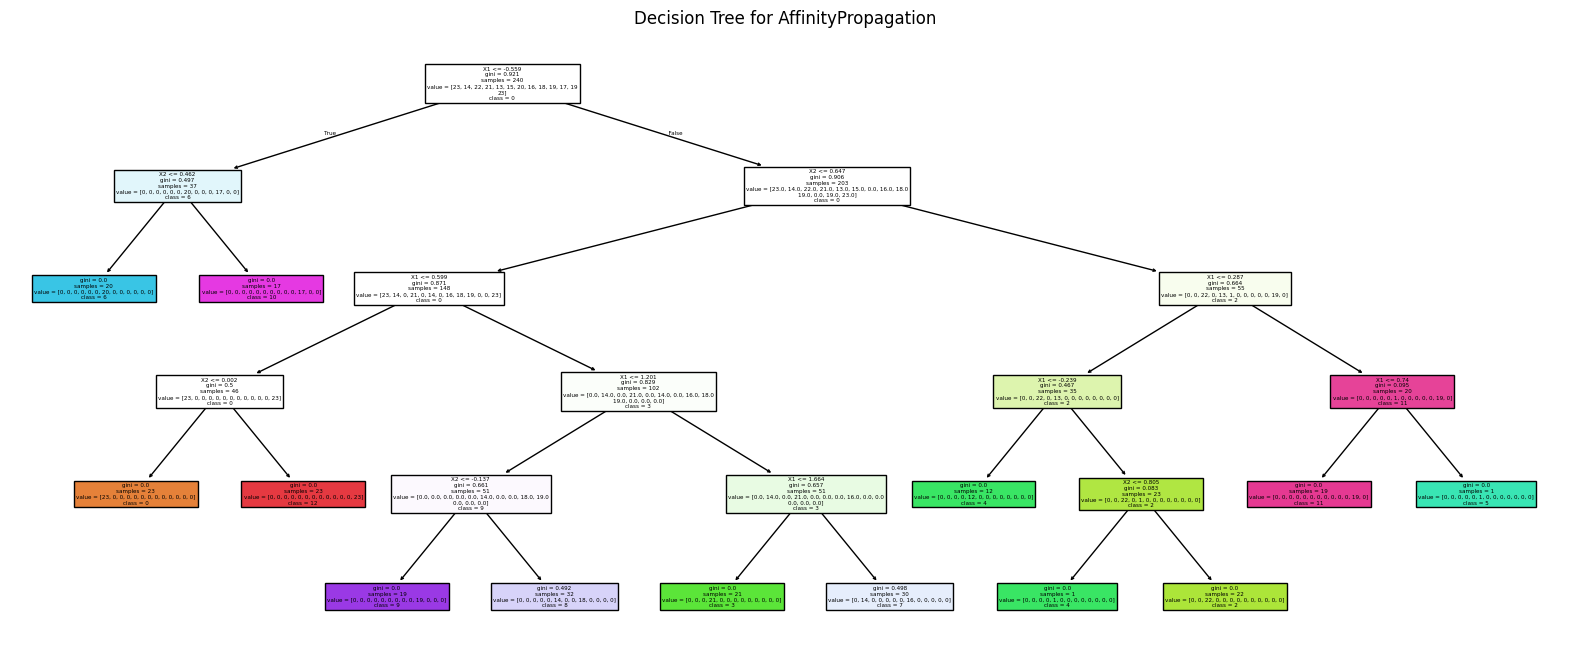

In [53]:
print('Decision Tree:')
plt.figure(figsize=(20, 8))
sk_tree.plot_tree(models['dtree'], filled=True, feature_names=moon.columns, class_names=np.unique(top_3_labels[top_3_algorithms.index[0]]).astype(str))
plt.title(f'Decision Tree for {top_3_algorithms.index[0]}')
plt.show()

In [50]:
print('DSGD Rules:')
models['ds'].print_most_important_rules(threshold=0.32)
print('--' * 40)

DSGD Rules:


Most important rules for class 0

	[0.543] R1: -0.115 < X1 < 0.477
			0: 0.295	1: 0.000	2: 0.282	3: 0.000	4: 0.000	5: 0.000	6: 0.000	7: 0.000	8: 0.000	9: 0.000	10: 0.000	11: 0.125	12: 0.298	Unc: 0.000

	[0.538] R4: X2 < -0.055
			0: 0.290	1: 0.000	2: 0.000	3: 0.287	4: 0.000	5: 0.000	6: 0.000	7: 0.137	8: 0.000	9: 0.286	10: 0.000	11: 0.000	12: 0.000	Unc: 0.000

Most important rules for class 1

	[0.567] R6: 0.272 < X2 < 0.599
			0: 0.000	1: 0.322	2: 0.000	3: 0.001	4: 0.000	5: 0.134	6: 0.105	7: 0.002	8: 0.077	9: 0.000	10: 0.114	11: 0.000	12: 0.246	Unc: 0.000

	[0.562] R3: X1 > 1.069
			0: 0.000	1: 0.318	2: 0.000	3: 0.277	4: 0.000	5: 0.000	6: 0.000	7: 0.263	8: 0.062	9: 0.074	10: 0.001	11: 0.000	12: 0.000	Unc: 0.005

	[0.406] R5: -0.055 < X2 < 0.272
			0: 0.029	1: 0.165	2: 0.000	3: 0.000	4: 0.000	5: 0.000	6: 0.206	7: 0.196	8: 0.195	9: 0.000	10: 0.000	11: 0.000	12: 0.208	Unc: 0.000

Most important rules for class 2

	[0.531] R1: -0.115 < X1 < 0.477
			0: 0.295	1: 0.000	2: 0.282

# Segundo algoritmo

In [60]:
#interpretamos primer algoritmo
models = saved_models[top_3_algorithms.index[1]]
print('Ripper Rules:')
models['ripper'].print_rules()

Ripper Rules:

Reglas para clase: 0
[[X2=<-0.41] V [X2=-0.25--0.057] V [X2=-0.41--0.25] V [X1=>1.75] V [X1=0.029-0.21^X2=-0.057-0.15] V [X1=-0.25-0.029^X2=0.28-0.42] V [X1=1.26-1.75] V [X1=0.029-0.21^X2=0.28-0.42] V [X2=0.42-0.58^X1=0.029-0.21] V [X1=-0.25-0.029^X2=0.42-0.58] V [X2=0.15-0.28^X1=0.029-0.21] V [X1=-0.25-0.029^X2=0.15-0.28] V [X1=0.21-0.44^X2=0.15-0.28] V [X1=-0.25-0.029^X2=-0.057-0.15]]

Reglas para clase: 1
[[X1=<-0.84] V [X2=0.8-0.91] V [X2=>0.91] V [X2=0.58-0.8] V [X1=0.72-0.9^X2=0.42-0.58] V [X1=0.9-1.26^X2=-0.057-0.15] V [X1=0.72-0.9^X2=0.15-0.28] V [X2=0.42-0.58^X1=0.9-1.26] V [X1=-0.84--0.25] V [X1=0.72-0.9^X2=-0.057-0.15] V [X2=0.28-0.42^X1=0.9-1.26] V [X1=0.44-0.72^X2=0.42-0.58] V [X1=0.72-0.9^X2=0.28-0.42] V [X1=0.9-1.26^X2=0.15-0.28]]


Decision Tree:


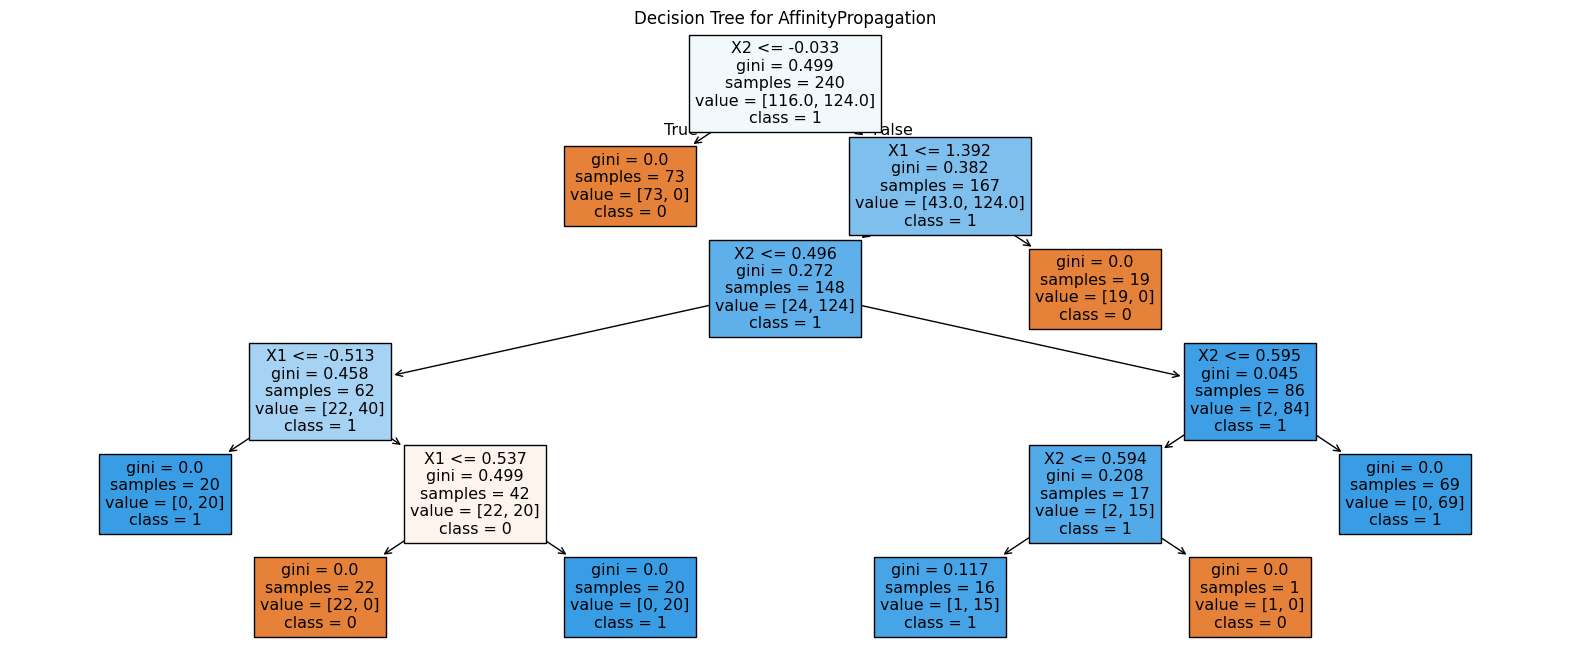

In [ ]:
print('Decision Tree:')
plt.figure(figsize=(20, 8))
sk_tree.plot_tree(models['dtree'], filled=True, feature_names=moon.columns, class_names=np.unique(top_3_labels[top_3_algorithms.index[1]]).astype(str))
plt.title(f'Decision Tree for {top_3_algorithms.index[0]}')
plt.show()

In [62]:
print('DSGD Rules:')
models['ds'].print_most_important_rules(threshold=0.32)
print('--' * 40)

DSGD Rules:


Most important rules for class 0

	[0.791] R4: X2 < -0.055
			0: 0.791	1: 0.000	Unc: 0.209

	[0.661] R3: X1 > 1.069
			0: 0.661	1: 0.000	Unc: 0.339

	[0.503] R1: -0.115 < X1 < 0.477
			0: 0.503	1: 0.000	Unc: 0.497

Most important rules for class 1

	[0.770] R7: X2 > 0.599
			0: 0.000	1: 0.770	Unc: 0.230

	[0.657] R0: X1 < -0.115
			0: 0.000	1: 0.657	Unc: 0.343

	[0.566] R2: 0.477 < X1 < 1.069
			0: 0.000	1: 0.566	Unc: 0.434
--------------------------------------------------------------------------------


# Tercer algoritmo

In [57]:
#interpretamos primer algoritmo
models = saved_models[top_3_algorithms.index[2]]
print('Ripper Rules:')
models['ripper'].print_rules()

Ripper Rules:

Reglas para clase: 0
[[X1=0.029-0.21] V [X1=0.21-0.44] V [X1=-0.84--0.25] V [X1=<-0.84] V [X1=-0.25-0.029] V [X2=0.58-0.8] V [X2=0.42-0.58^X1=0.72-0.9] V [X1=0.9-1.26^X2=-0.057-0.15] V [X1=0.9-1.26^X2=0.42-0.58] V [X2=0.28-0.42^X1=0.9-1.26] V [X2=0.15-0.28^X1=0.72-0.9] V [X2=0.15-0.28^X1=0.9-1.26] V [X1=0.44-0.72]]

Reglas para clase: 1
[[X1=>1.75] V [X1=1.26-1.75] V [X2=-0.41--0.25^X1=0.9-1.26] V [X2=<-0.41^X1=0.9-1.26] V [X2=<-0.41^X1=0.44-0.72] V [X2=-0.41--0.25^X1=0.72-0.9] V [X2=<-0.41^X1=0.72-0.9] V [X2=-0.41--0.25^X1=0.44-0.72]]


Decision Tree:


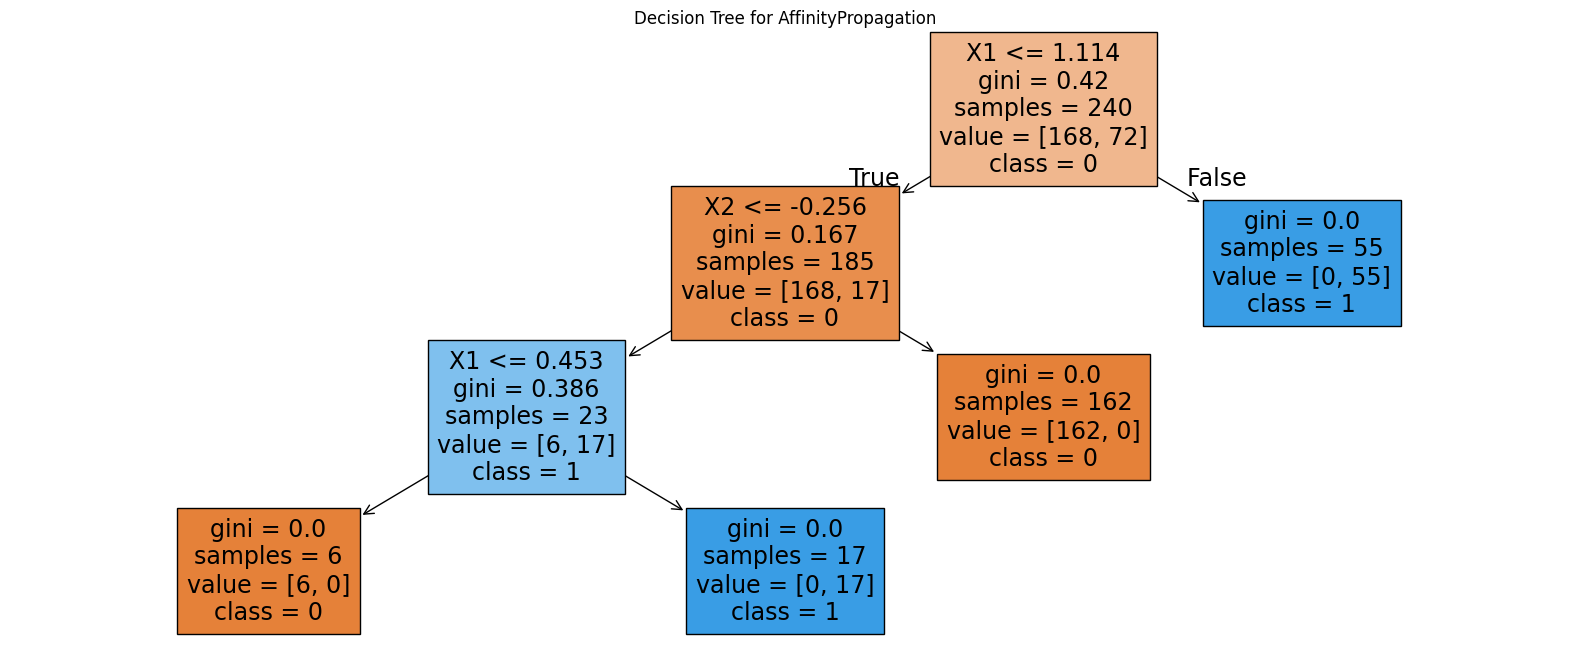

In [58]:
print('Decision Tree:')
plt.figure(figsize=(20, 8))
sk_tree.plot_tree(models['dtree'], filled=True, feature_names=moon.columns, class_names=np.unique(top_3_labels[top_3_algorithms.index[2]]).astype(str))
plt.title(f'Decision Tree for {top_3_algorithms.index[0]}')
plt.show()

In [59]:
print('DSGD Rules:')
models['ds'].print_most_important_rules(threshold=0.32)
print('--' * 40)

DSGD Rules:


Most important rules for class 0

	[0.726] R1: -0.115 < X1 < 0.477
			0: 0.726	1: 0.000	Unc: 0.274

	[0.722] R0: X1 < -0.115
			0: 0.722	1: 0.000	Unc: 0.278

	[0.645] R7: X2 > 0.599
			0: 0.645	1: 0.000	Unc: 0.355

	[0.557] R6: 0.272 < X2 < 0.599
			0: 0.557	1: 0.000	Unc: 0.443

	[0.530] R5: -0.055 < X2 < 0.272
			0: 0.530	1: 0.000	Unc: 0.470

	[0.392] R2: 0.477 < X1 < 1.069
			0: 0.380	1: 0.024	Unc: 0.596

Most important rules for class 1

	[0.806] R3: X1 > 1.069
			0: 0.000	1: 0.806	Unc: 0.194

	[0.537] R4: X2 < -0.055
			0: 0.000	1: 0.537	Unc: 0.463
--------------------------------------------------------------------------------
